In [207]:
# bibliotecas
import numpy as np
import scipy as sp
from numpy import pi, sin, cos, exp, sqrt, tan
import pylab as plt
import scipy.constants as cte
from scipy.constants import hbar, epsilon_0
from scipy.interpolate import interp1d
from scipy.integrate import quad, nquad
import timeit

In [208]:
# constantes do problema

deltaEc = 1.25*cte.e # altura do poco do eletron
deltaEv = 1.45*cte.e # altura do poco do buraco
me = cte.m_e*.15 # massa efetiva do eletron
mh = cte.m_e*0.14 # massa efetiva do buraco
cte_dielet = 4.96 # cte dieletrica
camadas = 5 # numero de camadas
a = camadas*.59e-9 # espessura do nanoplatelete

In [209]:
# definicao de algumas variaveis que serao utilizadas no codigo

global beta, lamb, V0, m, E

mi = 1/(1/me + 1/mh) # mu_perp
eps = cte_dielet*epsilon_0 # permissividade do material

### 1. Calcular o valor de $k$ do poço finito

O valor do $k$ é calculado pela equação transcendental

$$
    \tan{(ka/2)} = \kappa/k \qquad\Rightarrow\qquad \tan{(ka/2)} - \kappa/k = 0.
$$

O que será feito então é definir uma função a partir da última equação cuja sua variável é $E$ e encontrar a sua primeira raíz.

In [210]:
k = lambda E: sqrt(2*m*E)/hbar
kappa = lambda E: sqrt(2*m*(V0 - E))/hbar
f_transc = lambda E: tan(k(E)*a/2) - kappa(E)/k(E) # funcao transcendental do poco finito


"""
funcao que devolve a primeira raiz de uma funcao dado um 'range' x do seu domínio
e um 'range' y da sua imagem.

percorre x até encontrar dois pontos seguidos nos quais y muda de sinal, então chama a funcao
secante para encontrar a raíz entre esses pontos
"""
def raiz(x, y):
    for i in range(1, len(y)):
        if y[i]*y[i-1] < 0:
            raiz = secante(x[i-1], x[i])
            out = raiz
            break
    return out

"""
funcao que devolve a raiz de f_transc entre dois pontos E1 e E2

o calculo é feito utilizando o método da secante e a precisão do valor encontrado
é dada por epsilon
"""
def secante(E1, E2):
    global E
    E = E2
    epsilon = 1e-9
    while abs(f_transc(E2)) > epsilon:
        E1, E2 = E2, E2 - f_transc(E2)*(E2 - E1)/(f_transc(E2) - f_transc(E1))
        E = E2
    return E2

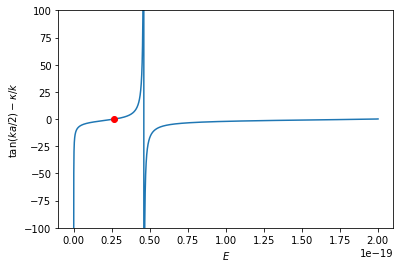

In [211]:
# valores para o eletron
V0 = deltaEc
m = me

eps_E = cte.e*1e-5 # epsilon da energia para evitar divergência da função f_transc em 0
Es = np.linspace(eps_E, deltaEc, 10000) # range na energia no qual será procurada a raíz
y = [f_transc(Ei) for Ei in Es]

# valor da energia de ligacao do elétron
Ee = raiz(Es, y)

k_e = k(Ee) # k do elétron
kappa_e = kappa(Ee) # kappa do elétron

# grafico para verificação visual da raíz encontrada
plt.plot(Es, y)
plt.plot(raiz(Es, y), 0, 'ro')
plt.ylim(-100, 100)
plt.ylabel(r'$\tan{(ka/2)} - \kappa/k$')
plt.xlabel(r'$E$')
plt.show()

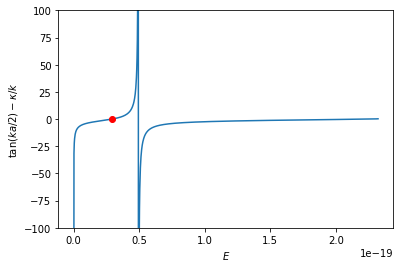

In [212]:
# valores para o buraco
V0 = deltaEv
m = mh

Es = np.linspace(eps_E, deltaEv, 1000) # range na energia no qual será procurada a raíz
y = [f_transc(Ei) for Ei in Es]

# valor da energia de ligacao do buraco
Eh = raiz(Es, y)

k_h = k(Eh) # k do buraco
kappa_h = kappa(Eh) # kappa do buraco

# grafico para verificação visual da raíz encontrada
plt.plot(Es, y)
plt.plot(raiz(Es, y), 0, 'ro')
plt.ylim(-100, 100)
plt.ylabel(r'$\tan{(ka/2)} - \kappa/k$')
plt.xlabel(r'$E$')
plt.show()

### 2. Cálculo das funções $\psi_e$ e $\psi_h$

A partir dos valores de $k$ encontrados para o elétron e para o buraco definimos uma função para a função de onda não normalizada de cada partícula pela equação 

\begin{equation}
    \psi(x)=
	\begin{cases}
	\cos(ka/2)\exp(\kappa a/2)\exp(\kappa x), &  x \leq -a/2\\
	\cos(kx), &  |x| \leq a/2\\
	\cos(ka/2)\exp(\kappa a/2)\exp(-\kappa x), &  x \geq a/2\\
	\end{cases}
\end{equation}

Isolando o $x$ no último caso obtemos

$$
    x = \frac{1}{\kappa}\ln\left[\frac{\cos(ka/2)e^{\kappa a/2}}{\psi(x)}\right]
$$

assim, dado um valor de $\psi(x)$ conseguimos encontrar o valor de $x$ em que isso ocorre. Para limitar o espaço em um tamanho infinito consideramos que $x$ é infinito quando $\psi(x) \sim 10^{-3}$.

In [213]:
# tamanho do infinito para a variavel a e 'dobro do infinito' para x
L = 2/kappa_e*np.log(cos(k_e*a/2)*exp(kappa_e*a/2)*1e3)

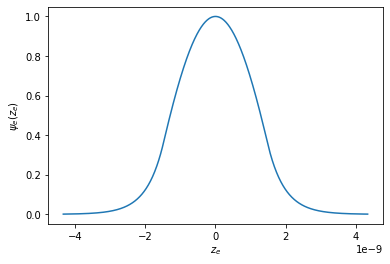

In [214]:
# funcao de onda do elétron em função da distância x
def psie(x):
    if x < -a/2:
        return cos(k_e*a/2)*exp(kappa_e*a/2)*exp(kappa_e*x)
    elif x < a/2:
        return cos(k_e*x)
    else:
        return cos(k_e*a/2)*exp(kappa_e*a/2)*exp(-kappa_e*x)

# gráfico para visualização da função de onda
xs = np.linspace(-L/2, L/2, 1000)
plt.plot(xs, [psie(xi) for xi in xs])
plt.ylabel(r'$\psi_e(z_e)$')
plt.xlabel(r'$z_e$')
plt.show()

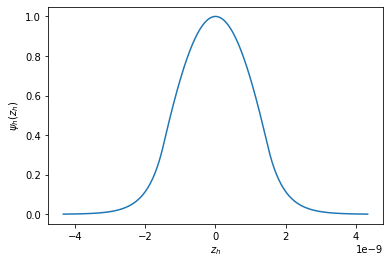

In [215]:
# funcao de onda do buraco em função da distância x
def psih(x):
    if x < -a/2:
        return cos(k_h*a/2)*exp(kappa_h*a/2)*exp(kappa_h*x)
    elif x < a/2:
        return cos(k_h*x)
    else:
        return cos(k_h*a/2)*exp(kappa_h*a/2)*exp(-kappa_h*x)

# gráfico para visualização da função de onda
xs = np.linspace(-L/2, L/2, 1000)
plt.plot(xs, [psih(xi) for xi in xs])
plt.ylabel(r'$\psi_h(z_h)$')
plt.xlabel(r'$z_h$')
plt.show()

### 3. Definição das funções perpendiculares

A função $p(a)$ é a seguinte integral
$$
    p(a) = \int^{L/2-a}_{-L/2} \psi_e^2(z+a)\psi_h^2(z) + \psi_e^2(z)\psi_h^2(z+a) dz,
$$
onde $a\in[0, \infty]$. Será feito uma interpolação para $p(a)$ pois assim seu valor em um ponto é calculado mais rapidamente, visto que não tem que passar pelos if.

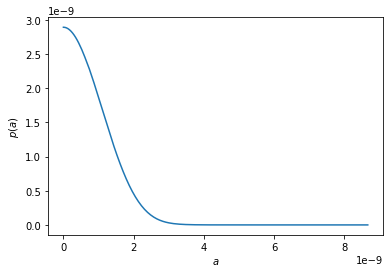

In [216]:
# p(a)
p_inte = lambda z, a: (psie(z+a)*psih(z))**2 + (psie(z)*psih(z+a))**2
p = lambda a: quad(p_inte, -L/2, L/2-a, args=(a))[0]

# interpolação da funcao p(a)
arange = np.linspace(0, L, 200)
prange = [p(i) for i in arange]
p = interp1d(arange, prange)

# gráfico para visualização da função p(a)
arange = np.linspace(0, L, 200)
plt.plot(arange, [p(ai) for ai in arange])
plt.ylabel(r'$p(a)$')
plt.xlabel(r'$a$')
plt.show()

As funções $F$, $G$, $J$ e $K$ são dadas por

$$
    F(a) = 2\pi \left(\frac{\lambda\sqrt{1 - \beta^2}a}{2} + \frac{\lambda^2}{4}\right) \exp\left(-\frac{2\sqrt{1-\beta^2}a}{\lambda}\right)
$$
$$
    G(a) = 2\pi \int^1_0 
    \frac{1-\omega^2}{\omega(1+\omega^2)}
    \left(a\frac{1-\beta^2}{\lambda}\right)^2
    \exp\left[-\frac{\sqrt{1-\beta^2}a}{\lambda}
    \left(\frac{1}{\omega}+\omega\right)\right]d\omega
$$
$$
    J_1 + J_3 = 2\pi
    \left(\frac{\sqrt{1 - \beta^2}a}{2\lambda} - \frac{1}{4}\right) \exp\left(-\frac{2\sqrt{1-\beta^2}a}{\lambda}\right)
$$
$$
    J_2 + J_4 = \pi\int^1_0
    a\sqrt{1-\beta^2}\left(\frac{1}{\omega^2} - 1\right)
    \left[-\frac{4}{\lambda(\omega+1/\omega)^2} - \frac{2a\sqrt{1 - \beta^2}}{(\omega+1/\omega)\lambda^2}\right]
    \exp\left[-\frac{a\sqrt{1-\beta^2}}{\lambda}\left(\omega+\frac{1}{\omega}\right)\right]d\omega
$$
$$
    K(a) = a\pi\beta\int^{\left(1-\sqrt{1-\beta^2}\right)\frac{1}{\beta}}_0
    \left(\frac{1}{\omega^2}-1\right)
    \exp\left[-\frac{a\beta}{\lambda}\left(\frac{1}{\omega}-\omega\right)\right]d\omega
$$

In [217]:
# F(a)
F = lambda a: 2*pi*(lamb*sqrt(1 - beta**2)*a/2 + lamb**2/4)*exp(-2*sqrt(1-beta**2)*a/lamb)

# G(a)
G_inte = lambda w, a: 2*pi*(1-w**2)/w/(1+w**2)*(a*(1-beta**2)/lamb)**2*exp(-sqrt(1-beta**2)*a/lamb*(1/w+w))
G = lambda a: quad(G_inte, 0, 1, args=(a))[0]

# J(a)
J13 = lambda a: 2*pi*(sqrt(1 - beta**2)*a/2/lamb - 1/4)*exp(-2*sqrt(1-beta**2)*a/lamb)
J24_inte = lambda w, a: pi*a*sqrt(1-beta**2)*(1/w**2 - 1)*(-4/lamb/(w+1/w)**2 - 2*a*sqrt(1 - beta**2)/(w+1/w)/lamb**2)*\
            exp(-a*sqrt(1-beta**2)/lamb*(w+1/w))
J24 = lambda a: quad(J24_inte, 0, 1, args=(a))[0]
J = lambda a: J13(a) + J24(a)

# K(a)
arange = np.linspace(0, L, 1000)
K_inte = lambda w, a: a*pi*beta*(1/w**2-1)*exp(-a*beta/lamb*(1/w-w))
K = lambda a: quad(K_inte, 0, (1-sqrt(1-beta**2))/beta, args=(a))[0]

### 4. Cálculo dos termos do hamiltoniano

Os termos finais a serem calculados são 

$$
    \mathcal{D} = \int^{L}_{0}p(a)F(a)da
$$
$$
    \mathcal{A} = E_e\mathcal{D} + \frac{\hbar^2}{2m^*_e}\int^{L}_0 p(a)G(a)da
$$
$$
    \mathcal{B} = E_h\mathcal{D} + \frac{\hbar^2}{2m^*_h}\int^{L}_0 p(a)G(a)da
$$
$$
    \mathcal{C} = \mathcal{C}_{\mathcal{T}} + \mathcal{C}_{\mathcal{V}} = -\frac{\hbar^2}{2\mu_\perp} \int^{L}_0 p(a)J(a)da - \frac{e^2}{4\pi\epsilon} \int^{L}_0 p(a)K(a)da
$$

In [220]:
"""
função que retorna o valor da energia calculada para os valores de lamb e beta atuais
"""
def E():
    
    atualiza() # atualiza as funções perpendiculares
    
    # calcula os valores de D, A, B e C
    D_inte = lambda a: p(a)*F(a)
    D = quad(D_inte, 0, L)[0]
    A_inte = lambda a: p(a)*G(a)
    aux = quad(A_inte, 0, L)[0]
    A = Ee*D + hbar**2/2/me*aux
    B = Eh*D + hbar**2/2/mh*aux
    C1_inte = lambda a: p(a)*J(a)
    C2_inte = lambda a: p(a)*K(a)
    CT = -hbar**2/2/mi*quad(C1_inte, 0, L)[0]
    CV = -cte.e**2/4/pi/eps*quad(C2_inte, 0, L)[0]
    C = CT + CV

    return (A + B + C)/D

"""
função que gera o gráfico com o valor da energia de ligação

é feita uma iteração em um 'range' de lamb e beta calculando a energia para cada ponto
"""
def final():
    
    ti = timeit.default_timer() # tempo inicial
    
    global beta, lamb
    
    betaini = .6 # valor inicial de beta
    betafin = 1 # valor final de beta
    n_beta = 100 # número de pontos para em beta
    beta_range = np.linspace(betaini, betafin, n_beta) # 'range' em beta
    
    lambini = 2.4 # valor inicial de lamb
    lambfin = 3.25 # valor final de lamb
    n_lamb = 100 # número de pontos para em lamb
    lamb_range = np.linspace(lambini*1e-9, lambfin*1e-9, n_lamb) # 'range' em lamb
    
    # definimos duas variáveis X e Y que são matrizes de dimensão n_range x n_beta
    # que são os valores de lamb e beta no plano beta x lamb
    X, Y = np.meshgrid(lamb_range, beta_range)
    
    # matriz n_range x n_beta para os valores de E
    Es = []
    
    for betai in beta_range:
        beta = betai
#         print('beta:', beta) # print opcional para mostrar qual valor de beta esta sendo calculado
        Es_aux = [] # lista com os valores de E para beta = betai
        for lambi in lamb_range:
            lamb = lambi
            Eb = E() - Ee - Eh # Eb = E - Ee - Eh
            Es_aux.append(Eb)
        Es.append(Es_aux)
    Es = np.array(Es)
    
    # acha o minimo e seus parametros
    energia = np.amin(Es)/cte.e*1e3 # Eb em meV
    lamb = lamb_range[np.where(Es == np.amin(Es))[1][0]]/1e-9 # lamb em nm
    beta = beta_range[np.where(Es == np.amin(Es))[0][0]]
    
    # grafico de E em função de lamb e beta
    # nome da figura final
    nome = 'nanoplatelet_' + str(camadas) + '_camadas_' +\
            str(n_lamb) + 'x' + str(n_beta) + '_pontos.svg'
    fig, ax = plt.subplots(1)
    im = ax.imshow(Es/1e-3/cte.e, origin='lower',
                   extent=[lambini, lambfin, betaini, betafin], aspect='auto')
    plt.xlabel(r'$\lambda$ (nm)')
    plt.ylabel(r'$\beta$')
    cb = plt.colorbar(im)
    cb.set_label(r'$E$ (meV)')
    plt.title(r'$E_B = $' + str(round(energia, 2)) + ' meV, ' +\
              r'$\lambda = $' + str(round(lamb, 2)) + ' nm, ' +\
              r'$\beta = $' + str(round(beta, 2)))
    plt.plot(lamb, beta, color='red', marker='.')
    plt.savefig(nome)
    plt.show()
    
    tf = timeit.default_timer() # tempo final
    print('Tempo de execucao:', round((tf - ti)/60, 3), 'minutos')

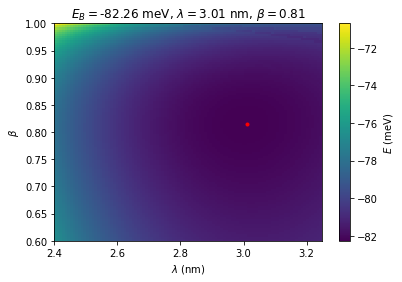

Tempo de execucao: 23.86 minutos


In [221]:
final()